# Data Cleansing
Text mining, N-grams

Data Source: [Amenities scraped from apartments.com](https://github.com/thuynh323/Web-Scrapers/blob/main/apartments.com/amenities.csv)

## Data Overview

In [1]:
import numpy as np
import pandas as pd
import random
import re
from datetime import datetime

from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

In [2]:
df1 = pd.read_csv(r'C:\Users\Thanh Huynh\Documents\Projects\apartment-rent\amenities.csv',
                  encoding= 'latin-1')

In [3]:
df1.head()

,apt_id,amenity_name,amenity_description
0,8507ch0,Unique Features,"['24/7 Package Access System', 'Bike Racks', '..."
1,8507ch0,Pet Policy,"['Dogs and Cats Allowed', '$20 Monthly Pet Ren..."
2,8507ch0,Parking,['Other']
3,8507ch0,Property Information,"['Built in 2020', '316 Units/5 Stories']"
4,8507ch0,Lease Length,"['13, 14']"


In [4]:
# Remove [] and '' from the amenity_description
df1['amenity_description'] = [x.replace("'", '').replace('[', '').replace(']', '') for x in df1['amenity_description']]
df1['amenity_description']

0       24/7 Package Access System, Bike Racks, Built-...
1       Dogs and Cats Allowed, $20 Monthly Pet Rent, $...
2                                                   Other
3                      Built in 2020, 316 Units/5 Stories
4                                                  13, 14
                              ...                        
8487                     Fitness Center, Pool, Playground
8488    High Speed Internet Access, Washer/Dryer Hooku...
8489    Dishwasher, Disposal, Ice Maker, Kitchen, Micr...
8490    Carpet, Tile Floors, Vinyl Flooring, Crown Mol...
8491    Controlled Access, Property Manager on Site, S...
Name: amenity_description, Length: 8492, dtype: object

In [5]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8492 entries, 0 to 8491
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   apt_id               8492 non-null   object
 1   amenity_name         8492 non-null   object
 2   amenity_description  8492 non-null   object
dtypes: object(3)
memory usage: 199.2+ KB


In [6]:
df1.describe()

,apt_id,amenity_name,amenity_description
count,8492,8492,8492
unique,693,14,5168
top,csy2bse,Property Information,None
freq,14,693,219


In [7]:
# How many rows in each section
df1['amenity_name'].value_counts()

Property Information    693
Pet Policy              686
Fitness & Recreation    680
Features                679
Lease Length            669
Kitchen                 664
Unique Features         661
Outdoor Space           661
Parking                 660
Services                641
Living Space            630
Interior                613
Security                522
Student Features         33
Name: amenity_name, dtype: int64

## Create dummies

In [8]:
# Create functions
def amenity_list(amenity_name):
    """ Returns a list of unique phrases that mentioned in a certain section
    """
    my_set = set(', '.join(df1[df1['amenity_name'] == amenity_name]['amenity_description'].unique()).split(', '))
    repr_list = [x.lower() for x in list(my_set)]
    return repr_list

def join_df(df, amenity_name):
    """ Joins data from one section to a base dataframe by apartment id
    """
    data = df.join(df1[df1['amenity_name'] == amenity_name][['apt_id', 'amenity_description']].set_index('apt_id'), how= 'left')
    return data

def amenity_dummies(df, key_word):
    """ Create dummies for each amenity by searching amenity names
    """
    word_list = [1 if (x is not np.nan) and (key_word in str(x).lower())
                 else 0 if (x is not np.nan) and (key_word not in str(x).lower())
                 else np.nan for x in df['amenity_description']]
    if len(word_list) > 0:
        return word_list
    else:
        return 'No word found' 

def amenitiy_dummy_loop(df, amenity_name):
    """ Iterate over different amenities to create dummies
    """
    data = join_df(df, amenity_name)
    for a in amenity_list(amenity_name):
        data['apt_' + a] = amenity_dummies(data, a)
    data.drop('amenity_description', axis=1, inplace=True)
    return data

In [9]:
# Print out unique phrases that mentioned in each amenity section
for a in list(df1['amenity_name'].unique()):
    value_list = amenity_list(a)
    if len(value_list) > 100:
        print(f'{a} - Too many unique values...')
        print('Sample of 20 unique values:')
        print(random.sample(value_list, 20))
    elif 0 < len(value_list) <= 100:
        print(f'{a} - List of {len(value_list)} unique values:')
        print(value_list)
    else:
        continue
    print('-------------------------------------\n')

Unique Features - Too many unique values...
Sample of 20 unique values:
['renovated unit', 'color package 2', 'fire pit and outdoor gathering area', 'yoga and spin studio', 'chestnut shaker-style cabinets', 'non-smoking community', 'sweeping views of midtown', 'professionally managed by arlington properties', 'skyline views*', 'covered parking deck', 'designer lighting package', 'built-in wine rack*', 'renovated and updated apartments', 'shopping', 'sleek quartz countertops', '1st floor woods view', 'car care center with vacuums', 'extended living room', '4 bedroom & townhome floor plans available', 'courtyard b']
-------------------------------------

Pet Policy - Too many unique values...
Sample of 20 unique values:
['restrictions: breed restrictions apply $20 monthly pet rent', 'please call our leasing office. comments: max 2 pets $40 monthly pet rent', 'no pet deposit no pet rent', 'comments: we accept large breeds', 'restrictions: please contract the office for breed and weight re

In [10]:
# Create multiple dummies in each section
df2 = pd.DataFrame(df1['apt_id'].unique()).rename(columns= {0: 'apt_id'}).set_index('apt_id')
amenities_to_dummies = ['Services', 'Interior', 'Outdoor Space', 'Fitness & Recreation',
                        'Features', 'Kitchen', 'Living Space', 'Security', 'Student Features']
for a in amenities_to_dummies:
    df2 = amenitiy_dummy_loop(df2, a)

In [11]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 693 entries, 8507ch0 to 91hhw97
Columns: 165 entries, apt_grocery service to apt_individual locking bedrooms
dtypes: float64(165)
memory usage: 918.7+ KB


In [12]:
df2.head()

,apt_grocery service,apt_renters insurance program,apt_doorman,apt_maintenance on site,apt_wi-fi at pool and clubhouse,apt_pet washing station,apt_on-site retail,apt_day care,apt_online services,apt_laundry service,...,apt_video patrol,apt_property manager on site,apt_controlled access,apt_shuttle to campus,apt_individual leases available,apt_study lounge,apt_walk to campus,apt_private bathroom,apt_roommate matching,apt_individual locking bedrooms
apt_id,,,,,,,,,,,,,,,,,,,,,
8507ch0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7x1j2ly,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3zjvf3d,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vfz0lqd,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fffnhjs,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Plot N-grams

In [13]:
# Funtions to get ngrams and their plots
def get_top_ngrams(corpus, ngram_range, stopwords_excluded= False, N= None):
    """
    Returns a dataframe of ngrams and their frequency
    corpus -- the series of amenity values of interest
    ngram_range -- the tuple of min and max ngram value
    stopwords_exclude -- take stopwords into account or not
    N -- pick top N ngrams
    """
    if stopwords_excluded:
        vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
    else:
        vec = CountVectorizer(ngram_range=ngram_range).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return pd.DataFrame(words_freq[:N], columns=['word', 'frequency']).sort_values('frequency')

def plot_ngrams(amenity_name, figsize, N= None):
    """
    Returns a plot of 4 subplots: 2 bigram plots and 2 trigram plots.
    Including and excluding stop words
    """
    corpus = df1[df1['amenity_name'] == amenity_name]['amenity_description']
    bigrams_df1 = get_top_ngrams(corpus, ngram_range= (2,2), N= N)
    bigrams_df2 = get_top_ngrams(corpus, ngram_range= (2,2), stopwords_excluded= True, N= N)
    trigrams_df1 = get_top_ngrams(corpus, ngram_range= (3,3), N= N)
    trigrams_df1 = get_top_ngrams(corpus, ngram_range= (3,3), stopwords_excluded= True, N= N)
    df = [bigrams_df1, bigrams_df2, trigrams_df1, trigrams_df1]

    fig = plt.figure(figsize= figsize)
    layout = (2,2)
    bigrams_ax1 = plt.subplot2grid(layout, (0,0))
    bigrams_ax2 = plt.subplot2grid(layout, (0,1))
    trigrams_ax1 = plt.subplot2grid(layout, (1,0))
    trigrams_ax2 = plt.subplot2grid(layout, (1,1))

    bigrams_ax1.set_title(f'Top {N} bigrams mentioned in\n {amenity_name}, including stop words.')
    bigrams_ax2.set_title(f'Top {N} bigrams mentioned in\n {amenity_name}, excluding stop words.')
    trigrams_ax1.set_title(f'Top {N} trigrams mentioned in\n {amenity_name}, including stop words.')
    trigrams_ax2.set_title(f'Top {N} trigrams mentioned in\n {amenity_name}, excluding stop words.')
    
    axes = [bigrams_ax1, bigrams_ax2, trigrams_ax1, trigrams_ax2]

    for a, d in zip(axes, df):
        a.barh(d['word'], d['frequency'])
    sns.despine()
    plt.tight_layout()

def find_key_words(amenity_name, key_word):
    """ Returns unique phrases that contain certain key words in a section
    """
    word_list = []
    for a in amenity_list(amenity_name):
        if key_word in a:
            word_list.append(a)
        else:
            continue
    if len(word_list) > 0:
        return word_list
    else:
        return 'Words are not found'

### Unique Features

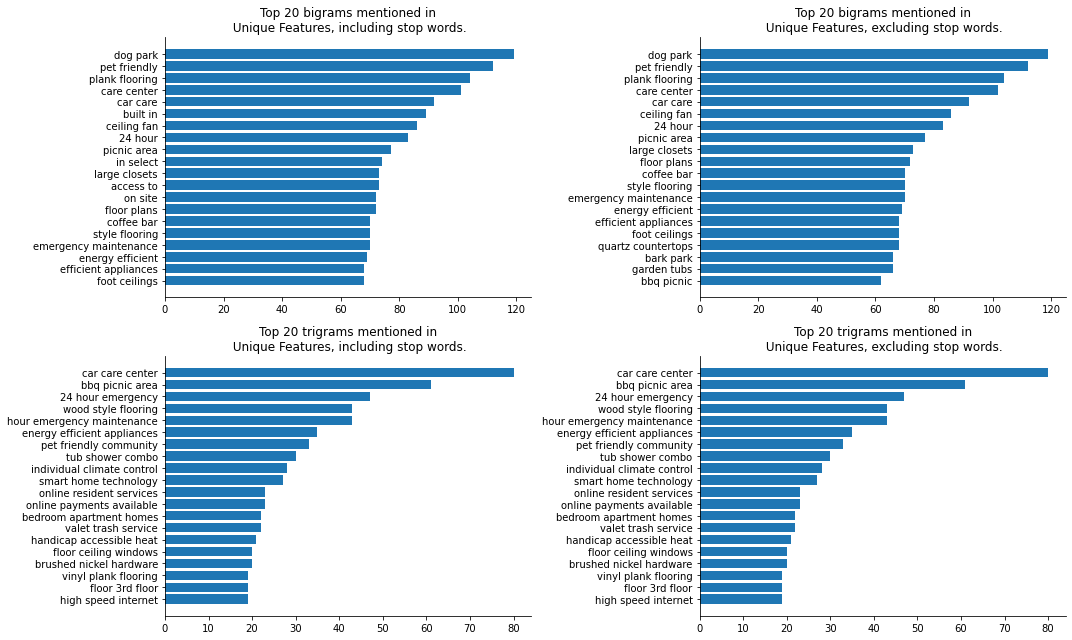

In [14]:
plot_ngrams('Unique Features', (15,9), N=20)

In [15]:
key_words = ['pet', 'bark', 'dog park', 'include']
for k in key_words:
    print(f'Values in Unique Features that contain "{k}".')
    print(find_key_words('Unique Features', k))
    print('-------------------------------------\n')

Values in Unique Features that contain "pet".
['truly pet-friendly community offering dedicated dog parks for large and small breed dogs', 'pets welcome', 'pets are welcome', 'pet friendly community with play park', 'pet-friendly', 'pet friendly community', 'pet waste stations - dog park', 'pet-friendly (breed restrictions apply)', 'pet stations', 'pet friendly', 'leash free pet park w/ agility equipment', 'pet park', 'pet-friendly spaces', 'large pets accepted', 'pet salon', 'pet friendly with bark park', 'pet-friendly community with pet park', 'pet friendly - we love pets', 'large pets welcome', 'check out our pet park!', 'designated pet walking areas', 'pet park featuring agility equipment', 'leash free pet park', 'convenient pet park', 'pet friendly (breed restrictions apply)', 'pets friendly - breed restrictions apply', 'pampered pet park', 'pets (with limitations)', 'pet-friendly (breed restrictions may apply)', 'petfriendly', 'pet-friendly community with pet park', 'pet services

In [16]:
df2 = join_df(df2, 'Unique Features')

In [17]:
# Add columns indicating if an apartment is pet-friendly or not
# and if utilities included, partially or fully
df2['apt_pet_friendly'] = amenity_dummies(df2, 'pet')
df2['apt_pet_friendly'] = np.where(('dog park' in df2['amenity_description']) |
                                   ('bark' in df2['amenity_description']), 1, df2['apt_pet_friendly'])
df2['apt_utilities_included'] = amenity_dummies(df2, 'utilities included')

In [18]:
df2.drop('amenity_description', axis= 1, inplace= True)

### Pet Policy

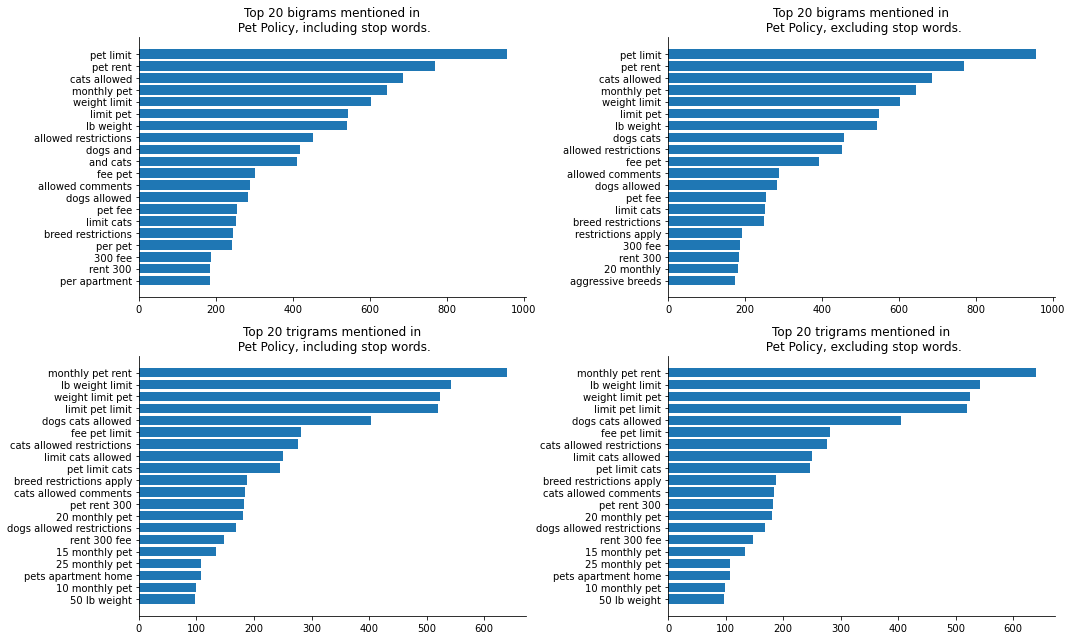

In [19]:
plot_ngrams('Pet Policy', (15,9), N=20)

In [20]:
key_words = ['not allowed', 'no pets allowed', 'no pet allowed']
for k in key_words:
    print(f'Values in Pet Policy that contain "{k}".')
    print(find_key_words('Pet Policy', k))
    print('-------------------------------------\n')

Values in Pet Policy that contain "not allowed".
['aggressive breeds not allowed. please call our leasing office for complete pet policy information. $60 monthly pet rent', 'restrictions: we welcome your pets for a maximum of 2 pets per apartment home. pet fee is $300 for the first pet and $150 for the second pet. there is a monthly pet rent of $15 per pet. the following breeds are not allowed: wolf or wolf hybrids', 'restrictions: aggressive breeds not allowed $20 monthly pet rent', 'and domestic fish. fees for these non-traditional acceptable pets may vary if applicable. restricted dog breeds are not allowed. for more information']
-------------------------------------

Values in Pet Policy that contain "no pets allowed".
['no pets allowed']
-------------------------------------

Values in Pet Policy that contain "no pet allowed".
Words are not found
-------------------------------------



In [21]:
df2 = join_df(df2, 'Pet Policy')

In [22]:
# Adjust apt_pet_friendly
df2['apt_pet_friendly'] = np.where(df2['amenity_description'].notna(), 1, df2['apt_pet_friendly'])
df2['apt_pet_friendly'] = np.where(df2['amenity_description'].notna() &
                                   ('no pets allowed' in df2['amenity_description'].notna()), 0, df2['apt_pet_friendly'])

In [23]:
df2.drop('amenity_description', axis= 1, inplace= True)

### Parking

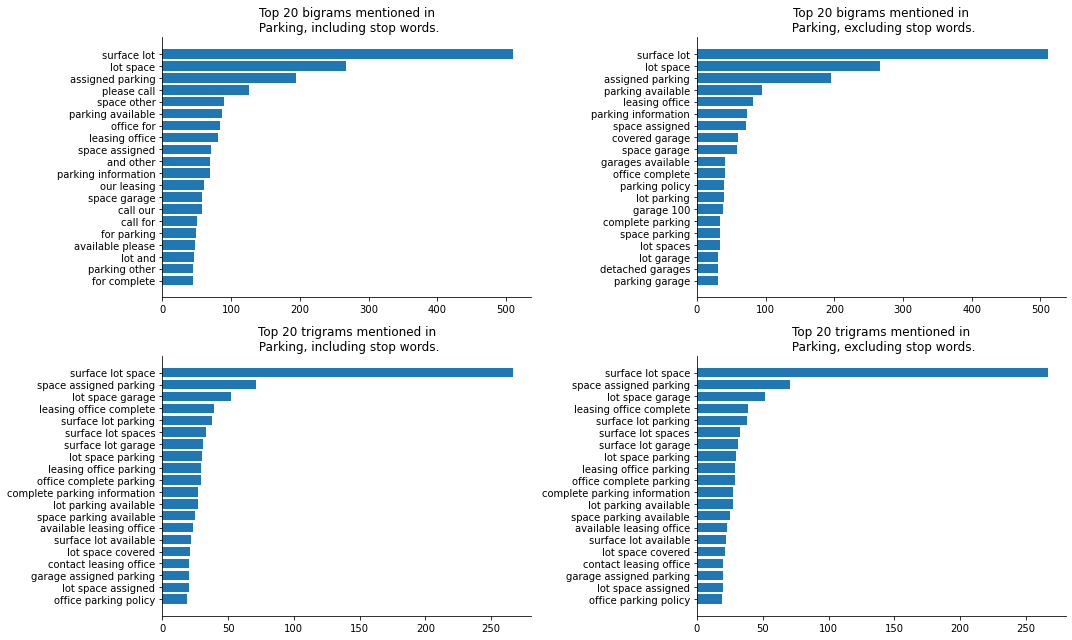

In [24]:
plot_ngrams('Parking', (15,9), N=20)

In [25]:
key_words = ['surface lot', 'garage']
for k in key_words:
    print(f'Values in Parking that contain "{k}".')
    print(find_key_words('Parking', k))
    print('-------------------------------------\n')

Values in Parking that contain "surface lot".
['1 space; assigned parking. garage units are available on a first come first served basis. the community has standard surface lot parking that is unassigned', 'surface lot available for select buildings.', 'surface lot: $18', 'surface lot and garages available. 1 vehicle per leaseholder', '1 space. surface lot parking available. please call our leasing office for more details.', '1 space. surface lot available. please call our leasing office for complete parking policy.', 'surface lot is available. please call our leasing office for complete parking information.', 'surface lot: $65', 'surface lot: $20', 'surface lot and garages available. please call our leasing office for parking policy.', 'assigned parking. surface lot and garages available. one assigned parking space per leaseholder. $55/month per vehicle. please contact leasing office for complete details.', 'surface lot: $15', 'surface lot and detached garages available. while there i

In [26]:
df2 = join_df(df2, 'Parking')

In [27]:
# Add columns indicating if an aprtment provides
# suface lot or garage
df2['apt_surface_lot'] = amenity_dummies(df2, 'surface lot')
df2['apt_garage'] = amenity_dummies(df2, 'garage')

In [28]:
df2.drop('amenity_description', axis= 1, inplace= True)

## More text mining
### Property Information

In [29]:
# Sample of Property Information
random.sample(amenity_list('Property Information'), 20)

['216 units/6 stories',
 '330 units/3 stories',
 '93 units/2 stories',
 '144 units/3 stories',
 '374 units/3 stories',
 'renovated in feb 2019',
 '165 units/2 stories',
 '283 units/5 stories',
 '311 units/6 stories',
 '498 units/4 stories',
 '647 units/26 stories',
 '336 units/17 stories',
 '397 units/4 stories',
 '396 units/3 stories',
 '300 units/3 stories',
 '296 units',
 'renovated in jan 2000',
 '348 units/6 stories',
 'renovated in jan 2013',
 '140 units/2 stories']

In [30]:
df2 = join_df(df2, 'Property Information')

In [31]:
# Extract potential year values
df2['year_extracted'] = df2['amenity_description'].str.findall(r'\d{4}')
df2['year_extracted']

apt_id
8507ch0    [2020]
7x1j2ly    [2020]
3zjvf3d    [2019]
vfz0lqd    [2020]
fffnhjs    [2020]
            ...  
vt0ejtg    [1911]
cm4nqkf    [1951]
nkfgrnp    [2020]
yqp921s    [2020]
91hhw97    [2005]
Name: year_extracted, Length: 693, dtype: object

In [32]:
# Check values that have more than 2 numbers
df2['num_extracted'] = [len(x) for x in df2['year_extracted']]
df2[df2['num_extracted'] == 3]['amenity_description']

apt_id
85ybms2    Built in 1986, Renovated in Jan 2016, 1738 Uni...
ezvc8wp    Built in 1985, Renovated in Jan 2016, 1180 Uni...
Name: amenity_description, dtype: object

In [33]:
# Extract potential year an apartment built and renovated
df2['apt_year_built'] = [int(x[0]) if len(x) >= 1 else np.nan for x in df2['year_extracted']]
df2['apt_year_renovated'] = [int(x[1]) if len(x) > 1 else np.nan for x in df2['year_extracted']]

In [34]:
df2[['apt_year_built', 'apt_year_renovated']].describe()

,apt_year_built,apt_year_renovated
count,690.000000,145.000000
mean,2000.736232,2006.703448
std,16.905869,84.383065
min,1911.000000,1000.000000
25%,1989.000000,2012.000000
50%,2001.000000,2015.000000
75%,2017.000000,2018.000000
max,2021.000000,2021.000000


We have the minimum is 1000, which does not seem right.

In [35]:
# Check if year values make sense
# If year built > year renovated
df2['year_diff'] = [x - y if (x is not np.nan) and (y is not np.nan)
                    else np.nan for x, y in zip(df2['apt_year_built'], df2['apt_year_renovated'])]
df2[df2['year_diff'] > 0]['amenity_description']

apt_id
sr9hlv4    Built in 1987, 1000 Units/2 Stories, Furnished
Name: amenity_description, dtype: object

In [36]:
# Calculate age of apartments
df2['apt_age'] = datetime.today().year - df2['apt_year_built']

# If an apartment has been renovated or not
df2['apt_renovated'] = np.where(df2['apt_year_renovated'].notna(), 1, 0)

# Correct year values for certain art_id if needed
df2.at['sr9hlv4', 'apt_renovated'] = 0

# Drop unnecessary columns
df2.drop(['amenity_description', 'year_extracted', 'num_extracted',
          'apt_year_built', 'apt_year_renovated', 'year_diff'], axis= 1, inplace= True)

### Lease Length

In [37]:
# Sample of Lease Length
random.sample(amenity_list('Lease Length'), 20)

['9 months',
 '3',
 'available months 12,13,14,15',
 'none',
 'variable lease terms offered.',
 '17 months',
 '6 - 14 month leases',
 'available months 7,8,9,10,11,12',
 '19 months',
 '3-13',
 '3-14',
 '7,9,12',
 '3-15 months',
 'we are offering 12 month lease terms at this time.',
 '6-12mo',
 '10',
 '17',
 '24 months',
 'available months 6,7,8,9,10,11,12',
 'and 12 months']

In [38]:
df2 = join_df(df2, 'Lease Length')

In [39]:
# Extract lease length values
df2['num_extracted'] = df2['amenity_description'].str.findall(r'\d+')
df2['num_extracted']

apt_id
8507ch0            [13, 14]
7x1j2ly    [12, 13, 14, 15]
3zjvf3d        [12, 13, 14]
vfz0lqd        [13, 14, 15]
fffnhjs            [13, 14]
                 ...       
vt0ejtg                 NaN
cm4nqkf                [12]
nkfgrnp                 NaN
yqp921s                 NaN
91hhw97                [12]
Name: num_extracted, Length: 693, dtype: object

In [40]:
# Check if there're other units
key_words = ['day', 'week', 'year']
for k in key_words:
    print(f'Values in Lease Length that contain "{k}".')
    print(find_key_words('Lease Length', k))
    print('-------------------------------------\n')

Values in Lease Length that contain "day".
Words are not found
-------------------------------------

Values in Lease Length that contain "week".
Words are not found
-------------------------------------

Values in Lease Length that contain "year".
['& 3 year', '1 year']
-------------------------------------



In [41]:
# Print out values that has lease length in years
for x in df2['amenity_description']:
    if 'year' in str(x).lower():
        print(df2.index[df2['amenity_description'] == x], x)

Index(['wvshvbl'], dtype='object', name='apt_id') 1,2, & 3 Year
Index(['wek49wl'], dtype='object', name='apt_id') 1 year


In [42]:
# Create min and max length columns
df2['apt_min_lease'] = [int(min(x)) if (x is not np.nan) and (len(x) > 1)
                        else int(x[0]) if (x is not np.nan) and (len(x) == 1)
                        else np.nan for x in df2['num_extracted']]
df2['apt_max_lease'] = [int(max(x)) if (x is not np.nan) and (len(x) > 1)
                        else int(x[0]) if (x is not np.nan) and (len(x) == 1)
                        else np.nan for x in df2['num_extracted']]

# Adjust values for apartments that have lease length in years
df2.at['wvshvbl', 'apt_min_lease'] = df2.at['wvshvbl', 'apt_min_lease']*12
df2.at['wvshvbl', 'apt_max_lease'] = df2.at['wvshvbl', 'apt_max_lease']*12
df2.at['wek49wl', 'apt_min_lease'] = df2.at['wek49wl', 'apt_min_lease']*12
df2.at['wek49wl', 'apt_max_lease'] = df2.at['wek49wl', 'apt_max_lease']*12

In [43]:
df2[['apt_min_lease', 'apt_max_lease']].describe()

,apt_min_lease,apt_max_lease
count,444.000000,444.000000
mean,10.768018,10.013514
std,2.317421,3.121295
min,1.000000,2.000000
25%,10.000000,9.000000
50%,10.000000,9.000000
75%,12.000000,12.000000
max,24.000000,36.000000


In [44]:
df2.drop(['amenity_description', 'num_extracted'], axis= 1, inplace= True)

### Expense dataset
Use data from the [expense dataset](https://github.com/thuynh323/Web-Scrapers/blob/main/apartments.com/expenses.csv) to fill in missing values or correct dummies of apt_utilities_included, apt_pet_friendly, apt_surface_lot, and apt_garage.

In [45]:
df3 = pd.read_csv(r'C:\Users\Thanh Huynh\Documents\Projects\apartment-rent\expenses.csv')
df3.head()

,apt_id,expense_type,expense_name,expense_amount
0,8507ch0,Recurring,Cat Rent,$20
1,8507ch0,Recurring,Dog Rent,$20
2,8507ch0,One-Time,Cat Fee,$300
3,8507ch0,One-Time,Dog Fee,$300
4,7x1j2ly,One-Time,Admin Fee,$150


In [46]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3528 entries, 0 to 3527
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   apt_id          3528 non-null   object
 1   expense_type    3528 non-null   object
 2   expense_name    3528 non-null   object
 3   expense_amount  3528 non-null   object
dtypes: object(4)
memory usage: 110.4+ KB


In [47]:
df3.describe()

,apt_id,expense_type,expense_name,expense_amount
count,3528,3528,3528,3528
unique,679,3,45,125
top,3qh4j7f,One-Time,Application Fee,$300
freq,11,2316,663,304


In [48]:
df3['expense_type'].value_counts()

One-Time              2316
Recurring             1137
Utilities Included      75
Name: expense_type, dtype: int64

In [49]:
# Explore the structure
df3['amount_extracted'] = df3['expense_amount'].str.findall(r'\d+')
df3['amount_extracted']

0        [20]
1        [20]
2       [300]
3       [300]
4       [150]
        ...  
3523    [300]
3524       []
3525     [19]
3526     [19]
3527       []
Name: amount_extracted, Length: 3528, dtype: object

In [50]:
# Check if there is non-number values
df3['num_extracted'] = [len(x) for x in df3['amount_extracted']]
df3[df3['num_extracted'] == 0][['expense_type', 'expense_name', 'expense_amount']].drop_duplicates()

,expense_type,expense_name,expense_amount
30,Utilities Included,Trash Removal,Included
238,Utilities Included,"Water, Trash Removal",Included
336,Utilities Included,"Gas, Water, Trash Removal, Sewer",Included
491,Utilities Included,"Water, Trash Removal, Sewer",Included
604,Utilities Included,Air Conditioning,Included
1058,Utilities Included,Water,Included
1909,Utilities Included,Gas,Included
1986,Utilities Included,"Water, Sewer",Included
2098,Utilities Included,"Water, Cable",Included
2459,Utilities Included,Cable,Included


In [51]:
# Double check if Utilities Included has other values
df3[df3['expense_type'] == 'Utilities Included']['expense_amount'].unique()

array(['Included'], dtype=object)

In [52]:
def fill_nans(amenity_name, fees):
    """
    Returns a dummy array that has missing values
    filled in/ corrected values with with new data
    """
    return np.where((df2[amenity_name] != 1) &
                    (df2[fees] == 1), 1,
                    df2[amenity_name])

In [53]:
# Join df2 with Utilities Included values
df2 = df2.join(df3[df3['expense_type'] == 'Utilities Included'][['apt_id', 'expense_amount']].groupby('apt_id').count(), how= 'left')

In [54]:
# Before applying the function
df2['apt_utilities_included'].value_counts()

0.0    660
1.0      1
Name: apt_utilities_included, dtype: int64

In [55]:
# Apply the function and check number of dummies again
df2['apt_utilities_included'] = fill_nans(amenity_name= 'apt_utilities_included',
                                          fees= 'expense_amount')
df2.drop('expense_amount', axis= 1, inplace= True)                                          
df2['apt_utilities_included'].value_counts()

0.0    595
1.0     76
Name: apt_utilities_included, dtype: int64

In [56]:
# What are one-time and recurring fees
print(f"One-Time fees:\n{list(df3[df3['expense_type'] == 'One-Time']['expense_name'].unique())}\n")
print(f"Recurring fees:\n{list(df3[df3['expense_type'] == 'Recurring']['expense_name'].unique())}")

One-Time fees:
['Cat Fee', 'Dog Fee', 'Admin Fee', 'Application Fee', 'Cat Deposit', 'Dog Deposit', 'Amenity Fee', 'Other', 'Bird Fee', 'Other Fee(s)', 'Fish Fee', 'Other Deposit(s)']

Recurring fees:
['Cat Rent', 'Dog Rent', 'Assigned Garage Parking', 'Storage Fee', 'Unassigned Garage Parking', 'Assigned Other Parking', 'Unassigned Surface Lot Parking', 'Unassigned Covered Parking', 'Assigned Covered Parking', 'Assigned Surface Lot Parking', 'Other Rent', 'Unassigned Other Parking', 'Bird Rent', 'Fish Rent']


In [57]:
# Group data apt_id and join expense_name
df3_grouped = pd.DataFrame(df3[(df3['expense_type'] == 'One-Time') |
                               (df3['expense_type'] == 'Recurring')][['apt_id', 'expense_name']].groupby('apt_id').apply(lambda x: ', '.join(x['expense_name'])), columns= ['fees'])
df3_grouped                      

,fees
apt_id,
01sbg83,"Admin Fee, Application Fee"
03k5ne1,"Admin Fee, Application Fee"
04q27w0,"Cat Rent, Dog Rent, Admin Fee, Application Fee..."
06vwf41,"Admin Fee, Application Fee"
06zptg3,"Storage Fee, Cat Rent, Dog Rent, Admin Fee, Ap..."
...,...
zs4zf8w,"Cat Rent, Dog Rent, Admin Fee, Application Fee"
zsltr9z,"Admin Fee, Application Fee"
zwcyjly,"Cat Rent, Dog Rent, Admin Fee, Application Fee..."


In [58]:
# Join df2 with this grouped data
df2 = df2.join(df3_grouped, how= 'left')

In [59]:
# Before applying the function
df2['apt_pet_friendly'].value_counts()

1.0    686
0.0      2
Name: apt_pet_friendly, dtype: int64

In [60]:
# Apply the function and check number of dummies again
df2['pets_related_fee'] = np.where(('Dog' in df2['fees']) |
                                   ('Cat' in df2['fees']) |
                                   ('Bird' in df2['fees']) |
                                   ('Fish' in df2['fees']),
                                   1, 0)
df2['apt_pet_friendly'] = fill_nans(amenity_name= 'apt_pet_friendly',
                                    fees= 'pets_related_fee')
df2.drop('pets_related_fee', axis= 1, inplace= True)
df2['apt_pet_friendly'].value_counts()

1.0    686
0.0      2
Name: apt_pet_friendly, dtype: int64

In [61]:
# Before applying the function
df2['apt_garage'].value_counts()

0.0    350
1.0    310
Name: apt_garage, dtype: int64

In [62]:
# Before applying the function
df2['apt_surface_lot'].value_counts()

1.0    473
0.0    187
Name: apt_surface_lot, dtype: int64

In [63]:
# Apply the function and check number of dummies again
df2['garage_related_fee'] = np.where(('Garage' in df2['fees']) |
                                     ('Covered' in df2['fees']),
                                     1, 0)
df2['surface_lot_related_fee'] = np.where('Surface Lot' in df2['fees'], 1, 0)                                     
df2['apt_garage'] = fill_nans(amenity_name= 'apt_garage',
                              fees= 'garage_related_fee')
df2['apt_surface_lot'] = fill_nans(amenity_name= 'apt_surface_lot',
                                   fees= 'surface_lot_related_fee')

In [64]:
df2['apt_garage'].value_counts()

0.0    350
1.0    310
Name: apt_garage, dtype: int64

In [65]:
df2['apt_surface_lot'].value_counts()

1.0    473
0.0    187
Name: apt_surface_lot, dtype: int64

In [66]:
# Drop unecessary
df2.drop(['fees', 'garage_related_fee', 'surface_lot_related_fee'], axis= 1, inplace= True)

## Final check and export

In [67]:
pd.set_option('display.max_columns', None)
df2.head()

,apt_grocery service,apt_renters insurance program,apt_doorman,apt_maintenance on site,apt_wi-fi at pool and clubhouse,apt_pet washing station,apt_on-site retail,apt_day care,apt_online services,apt_laundry service,apt_trash pickup - curbside,apt_car charging station,apt_public transportation,apt_recycling,apt_health club discount,apt_car wash area,apt_guest apartment,apt_community-wide wifi,apt_hearing impaired accessible,apt_pet care,apt_key fob entry,apt_24 hour availability,apt_shuttle to train,apt_meal service,apt_pet play area,apt_maid service,apt_furnished units available,apt_dry cleaning service,apt_composting,apt_planned social activities,apt_trash pickup - door to door,apt_vision impaired accessible,apt_house sitter services,apt_on-site atm,apt_package service,apt_laundry facilities,apt_elevator,apt_breakfast/coffee concierge,apt_conference room,apt_multi use room,apt_lounge,apt_business center,apt_corporate suites,apt_vintage building,apt_tanning salon,apt_disposal chutes,apt_clubhouse,apt_storage space,apt_courtyard,apt_patio,apt_garden,apt_pond,apt_gated,apt_balcony,apt_lake access,apt_grill,apt_dock,apt_porch,apt_fenced lot,apt_sundeck,apt_deck,apt_lawn,apt_zen garden,apt_picnic area,apt_roof terrace,apt_greenhouse,apt_cabana,apt_boat docks,apt_waterfront,apt_yard,apt_fitness center,apt_tennis court,apt_walking/biking trails,apt_basketball court,apt_racquetball court,apt_sauna,apt_gameroom,apt_golf course,apt_spa,apt_pool,apt_putting greens,apt_media center/movie theatre,apt_volleyball court,apt_playground,apt_bike storage,apt_air conditioning,apt_heating,apt_ceiling fans,apt_handrails,apt_wi-fi,apt_smoke free,apt_sprinkler system,apt_cable ready,apt_tub/shower,apt_framed mirrors,apt_washer/dryer - in unit,apt_vacuum system,apt_fireplace,apt_washer/dryer hookup,apt_intercom,apt_satellite tv,apt_surround sound,apt_wheelchair accessible (rooms),apt_double vanities,apt_trash compactor,apt_storage units,apt_high speed internet access,apt_kitchen,apt_dishwasher,apt_pantry,apt_breakfast nook,apt_refrigerator,apt_stainless steel appliances,apt_oven,apt_freezer,apt_microwave,apt_warming drawer,apt_coffee system,apt_ice maker,apt_island kitchen,apt_disposal,apt_range,apt_instant hot water,apt_eat-in kitchen,apt_granite countertops,apt_loft layout,apt_skylight,apt_bay window,apt_furnished,apt_wet bar,apt_dining room,apt_recreation room,apt_family room,apt_tile floors,apt_views,apt_basement,apt_walk-in closets,apt_hardwood floors,apt_den,apt_carpet,apt_linen closet,apt_window coverings,apt_office,apt_mud room,apt_crown molding,apt_large bedrooms,apt_built-in bookshelves,apt_vinyl flooring,apt_double pane windows,apt_workshop,apt_vaulted ceiling,apt_sunroom,apt_attic,apt_concierge,apt_security system,apt_video patrol,apt_property manager on site,apt_controlled access,apt_shuttle to campus,apt_individual leases available,apt_study lounge,apt_walk to campus,apt_private bathroom,apt_roommate matching,apt_individual locking bedrooms,apt_pet_friendly,apt_utilities_included,apt_surface_lot,apt_garage,apt_age,apt_renovated,apt_min_lease,apt_max_lease
apt_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8507ch0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,1.0,0,13.0,14.0
7x1j2ly,0.0,0.0,0.

In [68]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 693 entries, 8507ch0 to 91hhw97
Columns: 173 entries, apt_grocery service to apt_max_lease
dtypes: float64(172), int32(1)
memory usage: 959.3+ KB


In [69]:
df2.describe()

,apt_grocery service,apt_renters insurance program,apt_doorman,apt_maintenance on site,apt_wi-fi at pool and clubhouse,apt_pet washing station,apt_on-site retail,apt_day care,apt_online services,apt_laundry service,apt_trash pickup - curbside,apt_car charging station,apt_public transportation,apt_recycling,apt_health club discount,apt_car wash area,apt_guest apartment,apt_community-wide wifi,apt_hearing impaired accessible,apt_pet care,apt_key fob entry,apt_24 hour availability,apt_shuttle to train,apt_meal service,apt_pet play area,apt_maid service,apt_furnished units available,apt_dry cleaning service,apt_composting,apt_planned social activities,apt_trash pickup - door to door,apt_vision impaired accessible,apt_house sitter services,apt_on-site atm,apt_package service,apt_laundry facilities,apt_elevator,apt_breakfast/coffee concierge,apt_conference room,apt_multi use room,apt_lounge,apt_business center,apt_corporate suites,apt_vintage building,apt_tanning salon,apt_disposal chutes,apt_clubhouse,apt_storage space,apt_courtyard,apt_patio,apt_garden,apt_pond,apt_gated,apt_balcony,apt_lake access,apt_grill,apt_dock,apt_porch,apt_fenced lot,apt_sundeck,apt_deck,apt_lawn,apt_zen garden,apt_picnic area,apt_roof terrace,apt_greenhouse,apt_cabana,apt_boat docks,apt_waterfront,apt_yard,apt_fitness center,apt_tennis court,apt_walking/biking trails,apt_basketball court,apt_racquetball court,apt_sauna,apt_gameroom,apt_golf course,apt_spa,apt_pool,apt_putting greens,apt_media center/movie theatre,apt_volleyball court,apt_playground,apt_bike storage,apt_air conditioning,apt_heating,apt_ceiling fans,apt_handrails,apt_wi-fi,apt_smoke free,apt_sprinkler system,apt_cable ready,apt_tub/shower,apt_framed mirrors,apt_washer/dryer - in unit,apt_vacuum system,apt_fireplace,apt_washer/dryer hookup,apt_intercom,apt_satellite tv,apt_surround sound,apt_wheelchair accessible (rooms),apt_double vanities,apt_trash compactor,apt_storage units,apt_high speed internet access,apt_kitchen,apt_dishwasher,apt_pantry,apt_breakfast nook,apt_refrigerator,apt_stainless steel appliances,apt_oven,apt_freezer,apt_microwave,apt_warming drawer,apt_coffee system,apt_ice maker,apt_island kitchen,apt_disposal,apt_range,apt_instant hot water,apt_eat-in kitchen,apt_granite countertops,apt_loft layout,apt_skylight,apt_bay window,apt_furnished,apt_wet bar,apt_dining room,apt_recreation room,apt_family room,apt_tile floors,apt_views,apt_basement,apt_walk-in closets,apt_hardwood floors,apt_den,apt_carpet,apt_linen closet,apt_window coverings,apt_office,apt_mud room,apt_crown molding,apt_large bedrooms,apt_built-in bookshelves,apt_vinyl flooring,apt_double pane windows,apt_workshop,apt_vaulted ceiling,apt_sunroom,apt_attic,apt_concierge,apt_security system,apt_video patrol,apt_property manager on site,apt_controlled access,apt_shuttle to campus,apt_individual leases available,apt_study lounge,apt_walk to campus,apt_private bathroom,apt_roommate matching,apt_individual locking bedrooms,apt_pet_friendly,apt_utilities_included,apt_surface_lot,apt_garage,apt_age,apt_renovated,apt_min_lease,apt_max_lease
count,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641.00000,641.00000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,613.000000,613.000000,613.000000,613.000000,613.000000,613.000000,613.000000,613.000000,613.000000,613.000000,613.000000,613.000000,661.000000,661.000000,661.000000,661.000000,661.000000,661.000000,661.000000,661.000000,661.000000,661.000000,661.000000,661.000000,661.000000,661.000000,661.000000,661.000000,661.000000,661.000000,661.000000,661.000000,661.000000,661.000000,680.000000,680.000000,680.000000,680.000000,680.000000,680.000000,680.000000,680.000000,680.000000,680.000000,680.000000,680

In [70]:
df2.to_csv('cleaned_amenities.csv')